# 前処理

In [244]:
# load_data.ipynb にある関数 load_data() をモジュールとしてインポートするための記述
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
from load_data import load_data

import numpy as np

import cv2
from PIL import Image
import matplotlib.pyplot as plt
# plt.style.use('dark_background') # jupyterの背景を黒くしている場合， 混同行列などの軸ラベルが見やすくなる．
% matplotlib inline

from skimage import data
from skimage.filters import try_all_threshold

from sklearn.model_selection import train_test_split

### 機械学習のためのOpenCV入門
http://qiita.com/icoxfog417/items/53e61496ad980c41a08e#%E9%96%BE%E5%80%A4%E5%87%A6%E7%90%86  

**基本的な切り出し手順**
1. 前処理: 物体検出が行いやすいように、画像の前処理を行う
    - 物体の検出を行うには， 輪郭がはっきりしていて， 連続していると都合が良い．
    - 閾値処理やフィルター処理(ぼかし)が効果的な手法 * treshの値はペイントツールを使うのもあり．
    - 画像処理を行う場合， 大抵の場合はグレースケール化を行う． 
        - カラー情報が必要になる事はほとんどないため．
        - ただし， 最終的に機械学習で使用する際は， RGB情報が必要なことも多いため，
        画像から切り出しを行う際はカラーの方から行わなければならない．
        * opencvのimreadで読み込むと，RGBではなく，BGRになる．
      
2. 物体検出: 物体の検出を行い，画像から切り出す．
3. 輪郭検出: 画像上の領域(輪郭)を認識することで、物体を検出する．
4. 物体認識: OpenCVの学習済みモデルを利用して対象の物体を認識し，検出を行う．
5. 機械学習の準備: 切り出した画像を用い，予測や学習を行うための準備を行う．

## Thresholding(scikit - image)


http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_thresholding.html  


グレースケール画像からニ値画像を作る  
1. Histogram-based:各ピクセルの値のヒストグラムを元に，何らかの過程をおいて二値化する(例. 二峰性など)
2. Local：近くのピクセルのみを考慮する．計算量が多くなる．

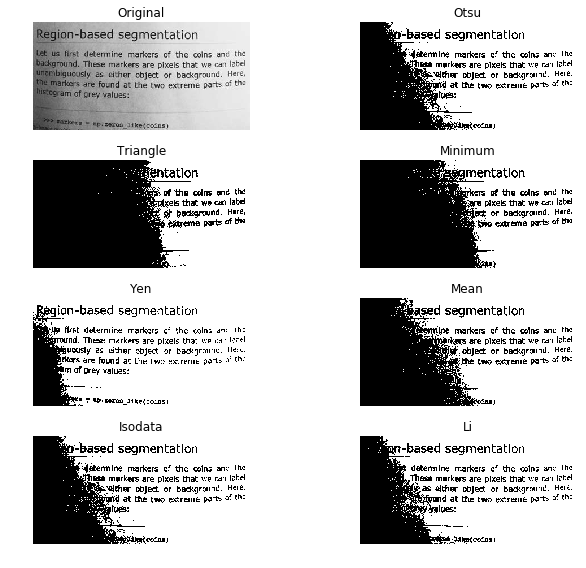

In [166]:
# サンプル
img = data.page()
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

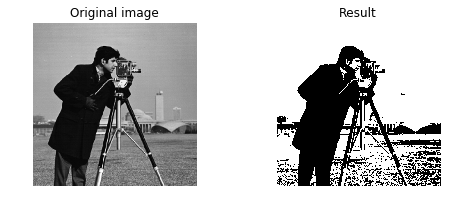

In [167]:
# 平均値を用いる場合 ← シンプルでナイーブ(単純，騙されやすい，素朴，原始的)な閾値
from skimage.filters import threshold_mean

image = data.camera()
thresh = threshold_mean(image) # 閾値
binary = image > thresh

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(binary, cmap=plt.cm.gray)
ax[1].set_title('Result')

for a in ax:
    a.axis('off')

plt.show()

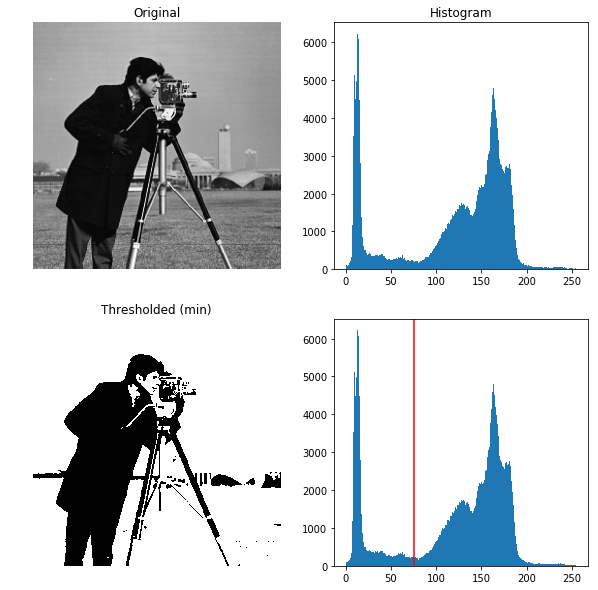

In [168]:
# Bimodal histgram
from skimage.filters import threshold_minimum

image = data.camera()

thresh_min = threshold_minimum(image)
binary_min = image > thresh_min

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].imshow(image, cmap=plt.cm.gray)
ax[0, 0].set_title('Original')

ax[0, 1].hist(image.ravel(), bins=256)
ax[0, 1].set_title('Histogram')

ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
ax[1, 0].set_title('Thresholded (min)')

ax[1, 1].hist(image.ravel(), bins=256)
ax[1, 1].axvline(thresh_min, color='r')

for a in ax[:, 0]:
    a.axis('off')
plt.show()

## データセットの準備
- 駒の種類ごとに，train:test = 7:3 に分割
- 並び順はランダム

In [234]:
# データの読み込み
koma = load_data() # 駒の種類．混同行列に利用．
class_names = koma.target_names
x = koma.data 
y = koma.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Chainerでは実数のタイプはfloat32, 整数のタイプはint32に固定しておく必要がある．
x_train = x_train.astype(np.float32) # (40681, 80, 64, 3)
y_train = y_train.astype(np.int32) # (40681,)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int32)

# 輝度を揃える
x_train /= x_train.max()
x_test /= x_test.max()

# データ数、形状の確認
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train: (38532, 80, 64, 3)
y_train: (38532,)
x_test: (16515, 80, 64, 3)
y_test: (16515,)


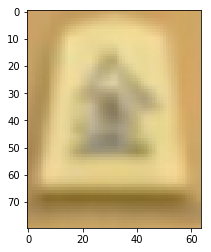

In [209]:
# サンプルの表示
plt.imshow(x_train[3])

###  方針
- まずは枠は許容して二値化して精度を求める
- ヨッシーさんに相談

###  知見
- 背景の白くする処理と境界をハッキリさせる処理でわけたほうがいい
- 矩形検出は8bitじゃないとダメではまった(chainerで処理できるようにdtype=np.float32としていたため)  
    - そもそも目的なく矩形検出しようとしていたところが問題

[[ 0.58073336  0.58214122  0.58606279 ...,  0.59612155  0.60008627
   0.59733725]
 [ 0.58073336  0.58214122  0.58214122 ...,  0.59612155  0.5961647
   0.5961647 ]
 [ 0.58214122  0.58214122  0.58399612 ...,  0.59612155  0.5961647
   0.59733725]
 ..., 
 [ 0.53429806  0.5421412   0.53979611 ...,  0.53821963  0.5421412
   0.53821963]
 [ 0.5457412   0.54966277  0.55358434 ...,  0.55985105  0.55985105
   0.55985105]
 [ 0.55997652  0.55908239  0.56300396 ...,  0.57962751  0.58354908
   0.58354908]]


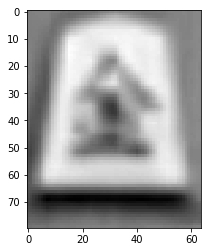

In [206]:
sample = x_train[3]
sample_gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)# グレースケール化
plt.imshow(sample_gray, cmap="gray")
print(sample_gray)

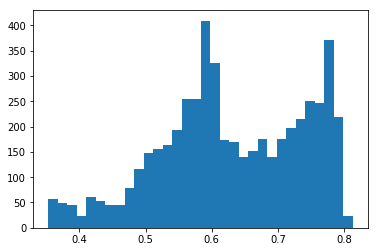

In [217]:
# ヒストグラムの確認
# for i in range(10):
i = 3
sample = x_train[i]
sample_gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)# グレースケール化
# plt.imshow(sample_gray, cmap="gray")
plt.hist(sample_gray.ravel(), bins=32) # ravel：一次元化
plt.show()

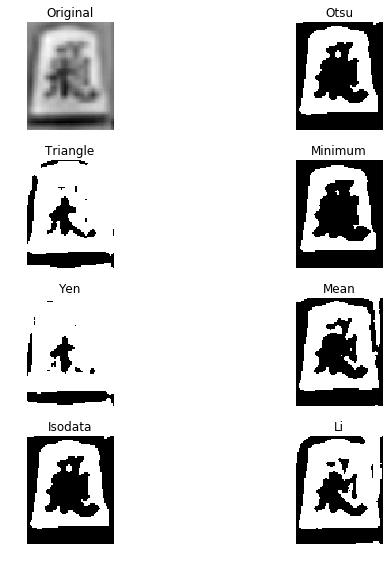

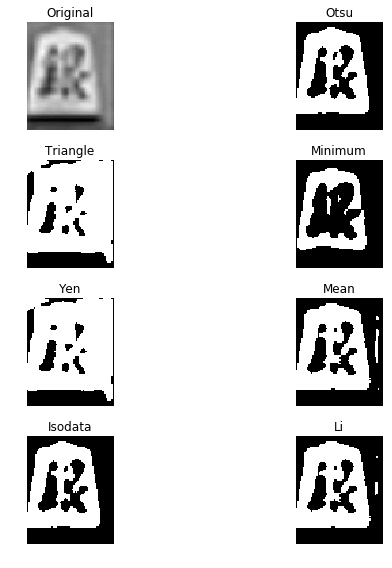

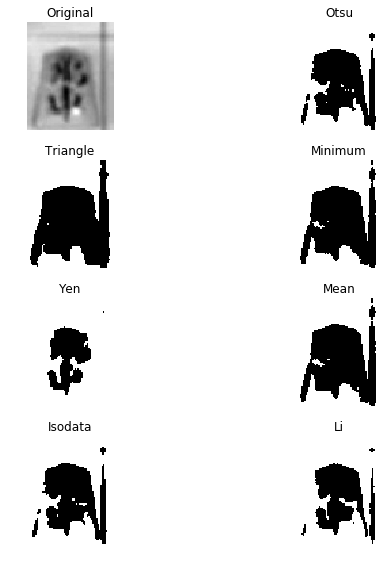

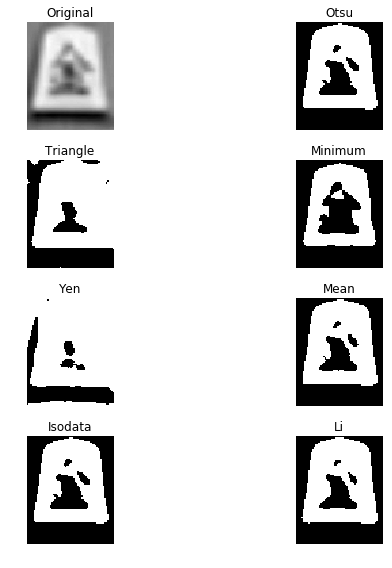

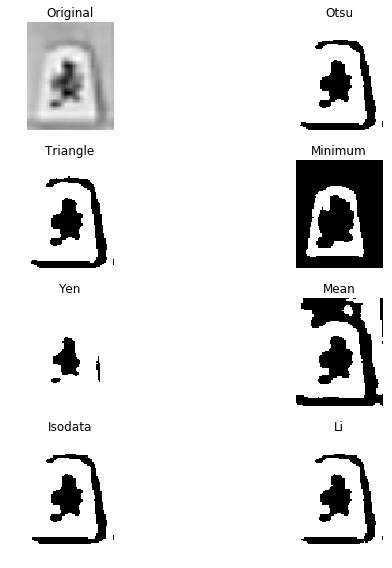

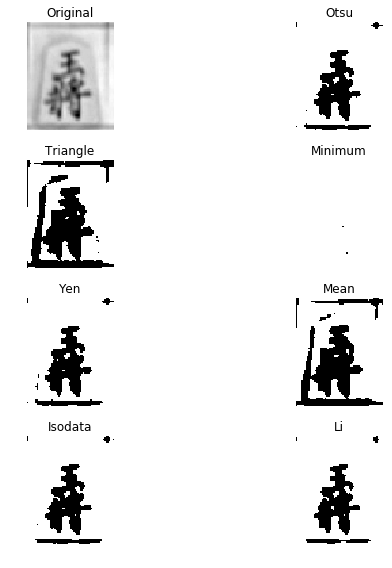

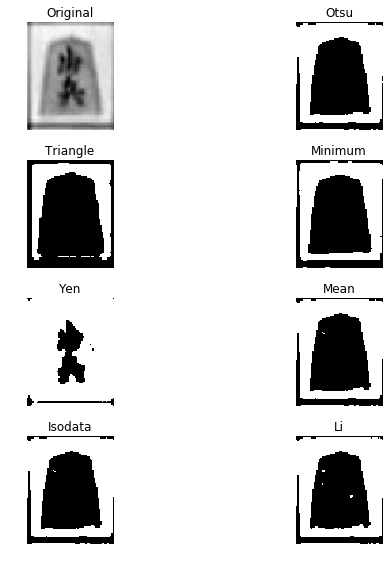

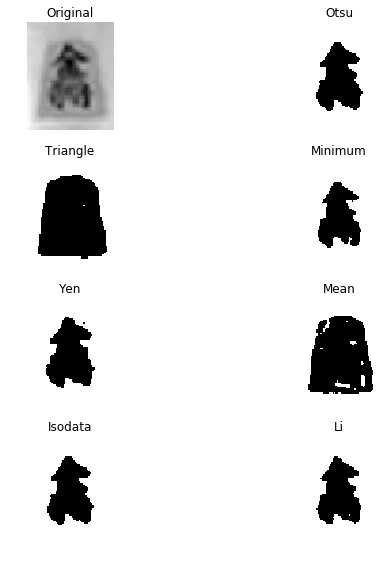

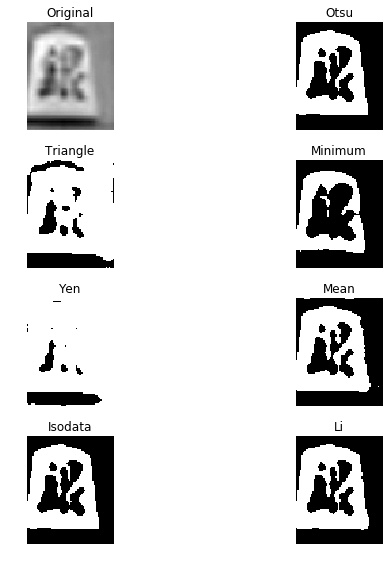

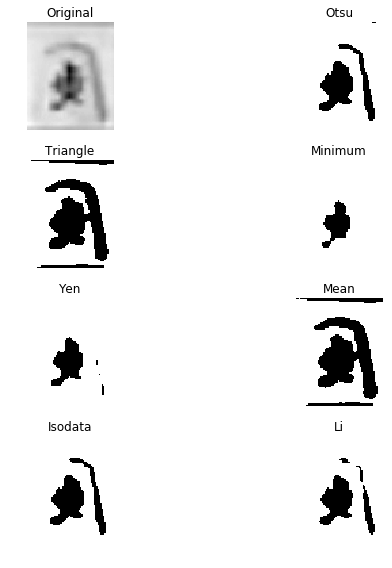

In [227]:
# サンプル
for i in range(10):
    sample = x_train[i]
    sample_gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)# グレースケール化
    img = sample_gray
    fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
    plt.show()

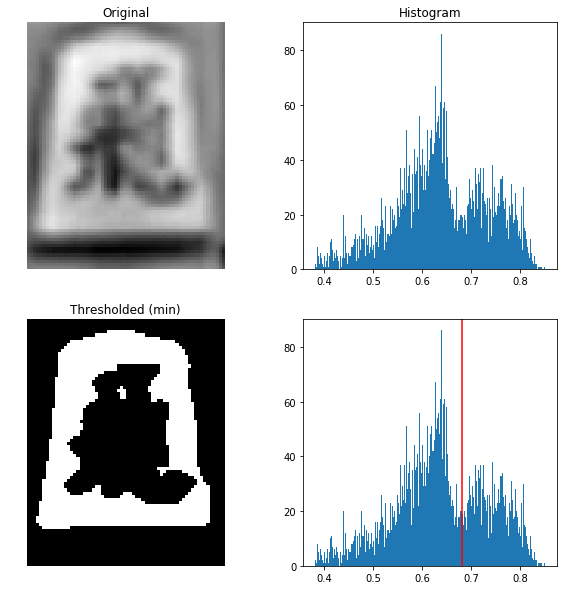

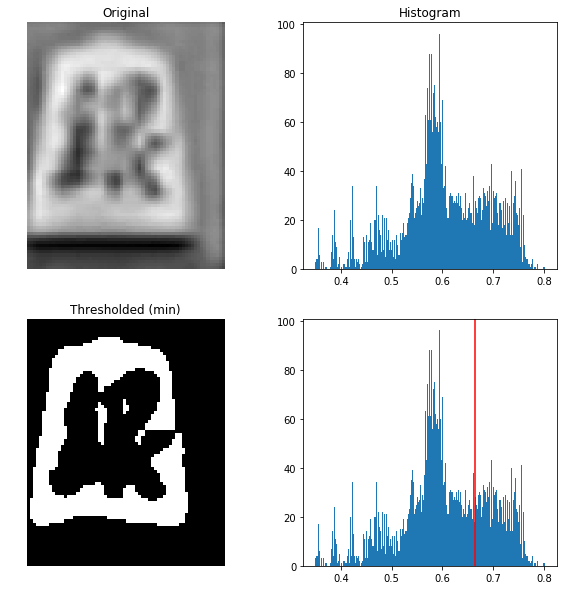

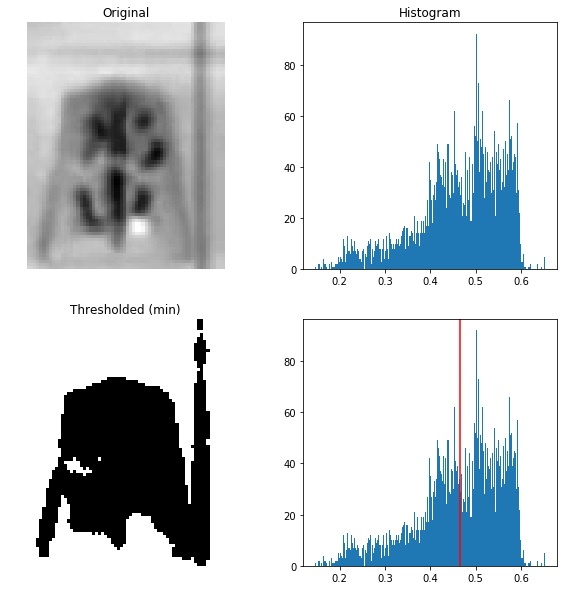

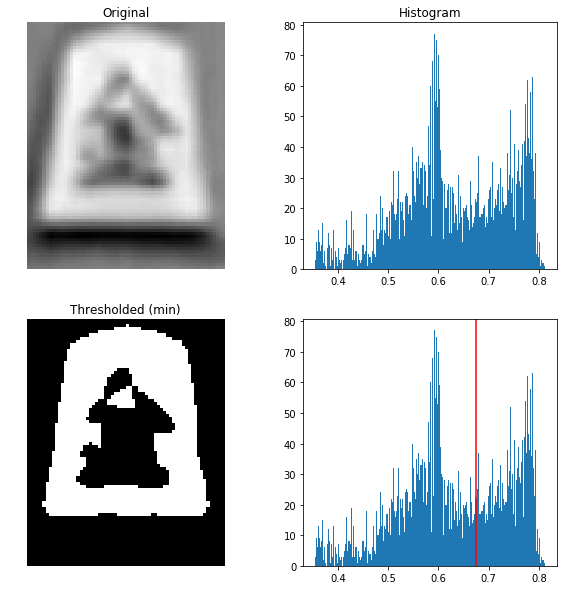

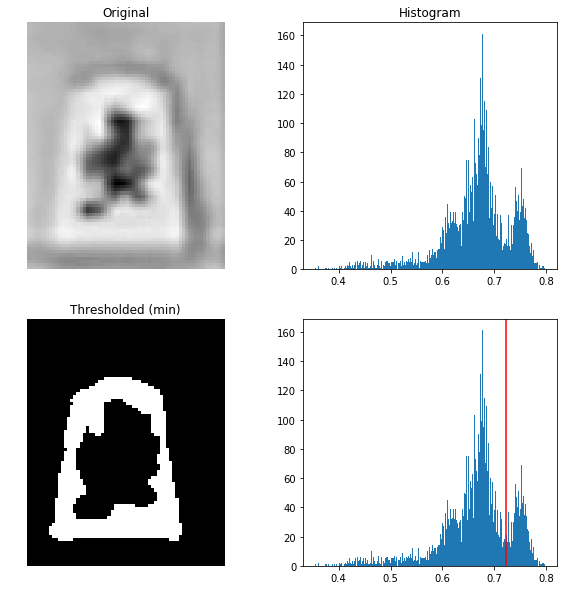

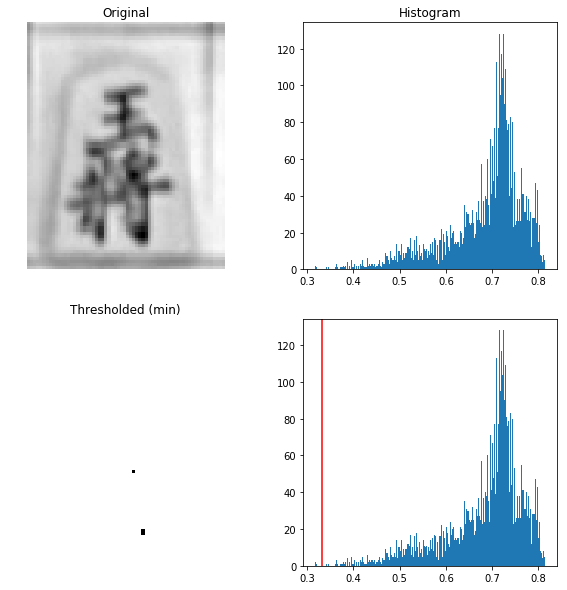

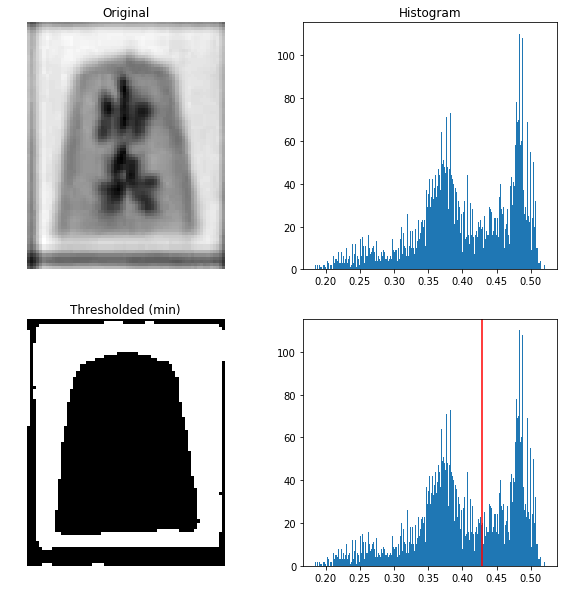

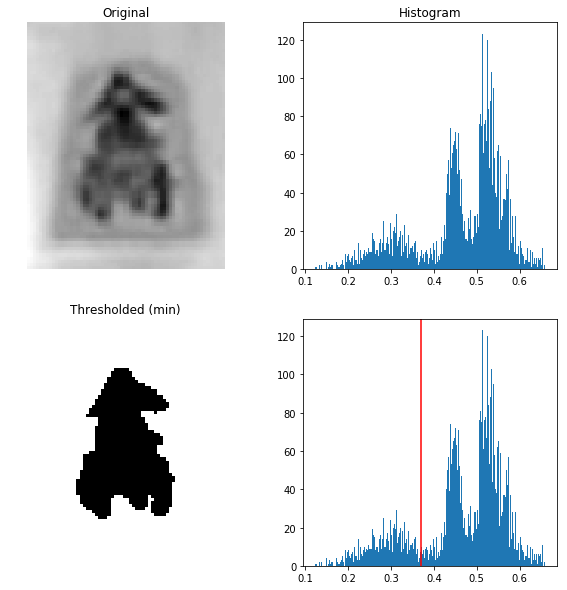

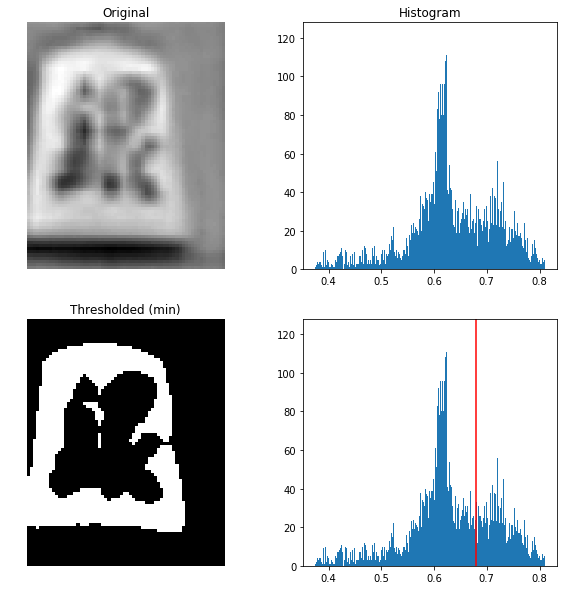

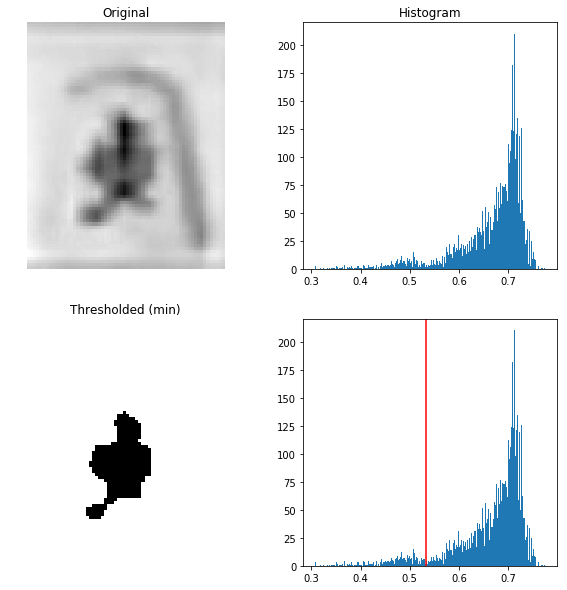

In [221]:
# Bimodal histgram
from skimage.filters import threshold_minimum

for i in range(10):
    sample = x_train[i]
    sample_gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)# グレースケール化
    image = sample_gray

    thresh_min = threshold_minimum(image)
    binary_min = image > thresh_min

    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    ax[0, 0].imshow(image, cmap=plt.cm.gray)
    ax[0, 0].set_title('Original')

    ax[0, 1].hist(image.ravel(), bins=256)
    ax[0, 1].set_title('Histogram')

    ax[1, 0].imshow(binary_min, cmap=plt.cm.gray)
    ax[1, 0].set_title('Thresholded (min)')

    ax[1, 1].hist(image.ravel(), bins=256)
    ax[1, 1].axvline(thresh_min, color='r')

    for a in ax[:, 0]:
        a.axis('off')
    plt.show()